# **Computational Drug Discovery - Covid inhibitors**

Building a machine learning model using the ChEMBL bioactivity data.

steps -<br> 
   >1) Performe Descriptor Calculation and Exploratory Data Analysis<br>
    2) Calculate molecular descriptors that are essentially quantitative description of the compounds in the dataset. <br>
    3) Prepare this into a dataset for subsequent model building.<br>
    4) Build a regression model of covid inhibitors using the random forest algorithm.<br>
    5) Compare several ML algorithms for build regression models of covid inhibitors.


## Installing the required libraries

In [2]:
#!pip install pandas
#!pip install np
#!pip install matplotlib
#!pip install sklearn
#!pip install chembl_webresource_client
#!pip install seaborn
##Now in order to install rkdit use 
!conda install -c conda-forge rdkit


In [6]:

import numpy as np # numpy is used to calculate the mean and standard deviation
import matplotlib.pyplot as plt # matplotlib is for drawing graphs
import matplotlib.colors as colors
from matplotlib import style

from rdkit import Chem
from chembl_webresource_client.new_client import new_client
from chembl_webresource_client import *
from collections import Counter
from operator import itemgetter
from rdkit.Chem import Descriptors, Lipinski
from scipy.stats import skew
import pandas_profiling
%matplotlib inline


# data visualization
import seaborn as sns
%matplotlib inline

# Algorithms
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.preprocessing import scale # scale and center data

### **Download PaDEL-Descriptor**

In [ ]:
! pip install padelpy
! pip install wget

In [ ]:
! python -m wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! python -m wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

In [8]:
from platform import python_version
python_version()

'3.8.8'

In [2]:
import pandas as pd

# Data Collection

Download a sample dataset. Let me talk a bit about this dataset. It is downloaded from the ChEMBL official website. It is a dataset of 6900 molecules related to the COVID-19 with their intrinsic properties

### **Target search for covid**

In [11]:
# Target search for covid-19
from chembl_webresource_client.new_client import new_client
target = new_client.target
target_query = target.search('SARS-Cov')
targets = pd.DataFrame.from_dict(target_query)
targets

cross_references  \
0                                                 []   
1                                                 []   
2                                                 []   
3                                                 []   
4  [{'xref_id': 'P0C6U8', 'xref_name': None, 'xre...   
5  [{'xref_id': 'P0C6X7', 'xref_name': None, 'xre...   
6                                                 []   

                                            organism  \
0  Severe acute respiratory syndrome-related coro...   
1    Severe acute respiratory syndrome coronavirus 2   
2                                   SARS coronavirus   
3                                       Homo sapiens   
4                                   SARS coronavirus   
5                                   SARS coronavirus   
6    Severe acute respiratory syndrome coronavirus 2   

                             pref_name  score  species_group_flag  \
0                             SARS-CoV   32.0               False   
1                           SARS-CoV-2   28.0               False   
2                     SARS coronavirus   15.0               False   
3     Serine--tRNA ligase, cytoplasmic   14.0               False   
4  SARS coronavirus 3C-like proteinase   11.0               False   
5            Replicase polyprotein 1ab    4.0               False   
6            Replicase polyprotein 1ab    4.0               False   

  target_chembl_id                                  target_components  \
0    CHEMBL4303836                                                 []   
1    CHEMBL4303835                                                 []   
2     CHEMBL612575                                                 []   
3    CHEMBL4523232  [{'accession': 'P49591', 'component_descriptio...   
4       CHEMBL3927  [{'accession': 'P0C6U8', 'component_descriptio...   
5       CHEMBL5118  [{'accession': 'P0C6X7', 'component_descriptio...   
6    CHEMBL4523582  [{'accession': 'P0DTD1', 'component_descriptio...   

      target_type   tax_id  
0        ORGANISM   694009  
1        ORGANISM  2697049  
2        ORGANISM   227859  
3  SINGLE PROTEIN     9606  
4  SINGLE PROTEIN   227859  
5  SINGLE PROTEIN   227859  
6  SINGLE PROTEIN  2697049

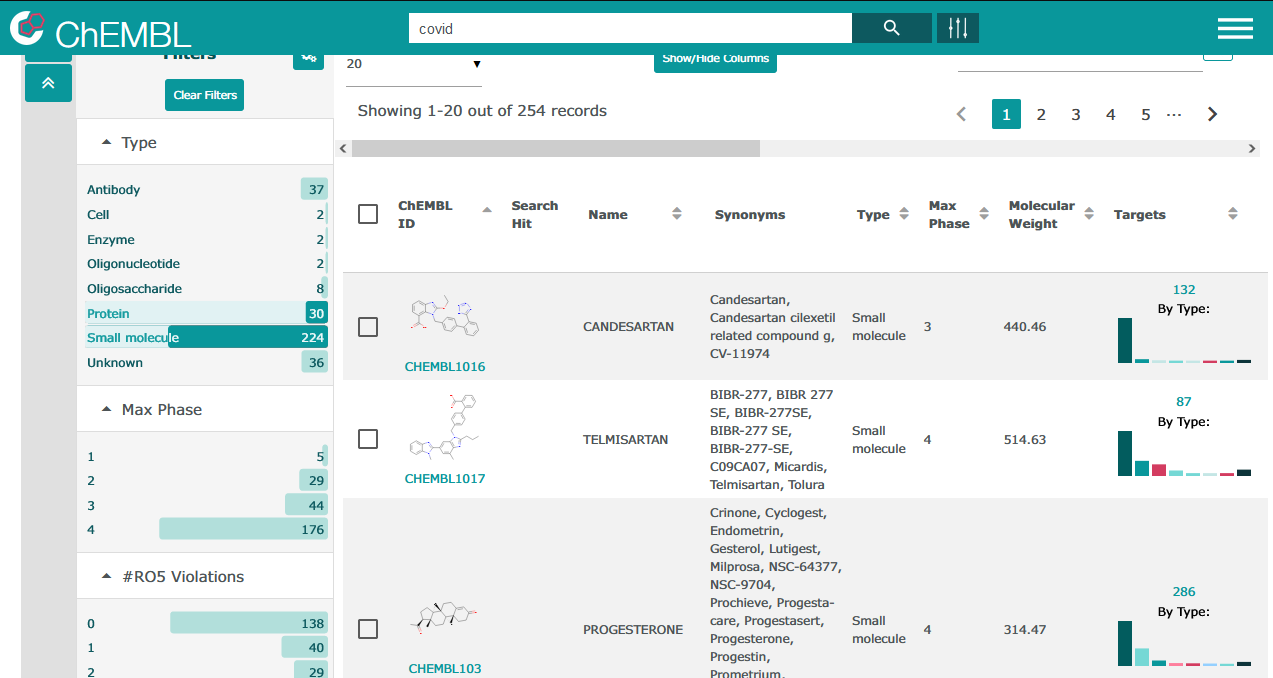

### Select and retrieve bio activity data of  SARS coronavirus 3C-like proteinase

In [12]:
selected_target = targets.target_chembl_id[6]
selected_target

'CHEMBL4523582'

In [13]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(res)

In [14]:
df.to_csv('SARS-Cov.csv', index=False)

In [25]:
df = pd.read_csv('SARS-Cov.csv',sep=',')

In [26]:
df

activity_comment  activity_id activity_properties assay_chembl_id  \
0    Dtt Insensitive     19964199                  []   CHEMBL4495583   
1    Dtt Insensitive     19964200                  []   CHEMBL4495583   
2    Dtt Insensitive     19964201                  []   CHEMBL4495583   
3    Dtt Insensitive     19964202                  []   CHEMBL4495583   
4    Dtt Insensitive     19964203                  []   CHEMBL4495583   
..               ...          ...                 ...             ...   
112  Dtt Insensitive     19964311                  []   CHEMBL4495583   
113  Dtt Insensitive     19964312                  []   CHEMBL4495583   
114  Dtt Insensitive     19964313                  []   CHEMBL4495583   
115  Dtt Insensitive     19964314                  []   CHEMBL4495583   
116  Dtt Insensitive     19964315                  []   CHEMBL4495583   

                                     assay_description assay_type  \
0    SARS-CoV-2 3CL-Pro protease inhibition IC50 de...          F   
1    SARS-CoV-2 3CL-Pro protease inhibition IC50 de...          F   
2    SARS-CoV-2 3CL-Pro protease inhibition IC50 de...          F   
3    SARS-CoV-2 3CL-Pro protease inhibition IC50 de...          F   
4    SARS-CoV-2 3CL-Pro protease inhibition IC50 de...          F   
..                                                 ...        ...   
112  SARS-CoV-2 3CL-Pro protease inhibition IC50 de...          F   
113  SARS-CoV-2 3CL-Pro protease inhibition IC50 de...          F   
114  SARS-CoV-2 3CL-Pro protease inhibition IC50 de...          F   
115  SARS-CoV-2 3CL-Pro protease inhibition IC50 de...          F   
116  SARS-CoV-2 3CL-Pro protease inhibition IC50 de...          F   

     assay_variant_accession  assay_variant_mutation bao_endpoint  \
0                        NaN                     NaN  BAO_0000190   
1                        NaN                     NaN  BAO_0000190   
2                        NaN                     NaN  BAO_0000190   
3                        NaN                     NaN  BAO_0000190   
4                        NaN                     NaN  BAO_0000190   
..                       ...                     ...          ...   
112                      NaN                     NaN  BAO_0000190   
113                      NaN                     NaN  BAO_0000190   
114                      NaN                     NaN  BAO_0000190   
115                      NaN                     NaN  BAO_0000190   
116                      NaN                     NaN  BAO_0000190   

      bao_format  ...                                  target_organism  \
0    BAO_0000019  ...  Severe acute respiratory syndrome coronavirus 2   
1    BAO_0000019  ...  Severe acute respiratory syndrome coronavirus 2   
2    BAO_0000019  ...  Severe acute respiratory syndrome coronavirus 2   
3    BAO_0000019  ...  Severe acute respiratory syndrome coronavirus 2   
4    BAO_0000019  ...  Severe acute respiratory syndrome coronavirus 2   
..           ...  ...                                              ...   
112  BAO_0000019  ...  Severe acute respiratory syndrome coronavirus 2   
113  BAO_0000019  ...  Severe acute respiratory syndrome coronavirus 2   
114  BAO_0000019  ...  Severe acute respiratory syndrome coronavirus 2   
115  BAO_0000019  ...  Severe acute respiratory syndrome coronavirus 2   
116  BAO_0000019  ...  Severe acute respiratory syndrome coronavirus 2   

              target_pref_name  target_tax_id  text_value toid  type  units  \
0    Replicase polyprotein 1ab        2697049         NaN  NaN  IC50     uM   
1    Replicase polyprotein 1ab        2697049         NaN  NaN  IC50     uM   
2    Replicase polyprotein 1ab        2697049         NaN  NaN  IC50     uM   
3    Replicase polyprotein 1ab        2697049         NaN  NaN  IC50     uM   
4    Replicase polyprotein 1ab        2697049         NaN  NaN  IC50     uM   
..                         ...            ...         ...  ...   ...    ...   
112  Replicase polyprotein 

In [27]:
df['canonical_smiles'][2]

'O=c1sn(-c2cccc3ccccc23)c(=O)n1Cc1ccccc1'

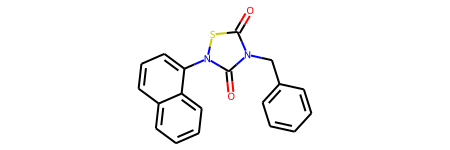

In [28]:
example = Chem.MolFromSmiles(df['canonical_smiles'][2])
example

In [29]:
def get_standard_value(chembl_id, standard_type):
    #Argument:
        #chembl_id : chemble id of the molecule
        #standard_type : IC50, ec50 etc
        
    #return: 
        #A (chembl_id, Bioactivity of the molecule)-tuple
    records = new_client.activity.filter(molecule_chembl_id=chembl_id).filter(standard_units='nM').filter(standard_type=standard_type)
    df = pd.DataFrame.from_dict(records)
    if len(df)>0:
        return (chembl_id,df['standard_value'][0])

In [32]:
x_list = list()
i=1
for chem_id in df['molecule_chembl_id']:
    f=get_standard_value(chem_id,'IC50')
    if f!= None:
        x_list.append(f)
        print(x_list[-1])
        print(f"{i}/{len(df['molecule_chembl_id'])}")
    i+=1
    print('----------------')

('CHEMBL480', '398.11')
1/117
----------------
('CHEMBL178459', '210.0')
2/117
----------------
('CHEMBL3545157', '60.0')
3/117
----------------
('CHEMBL297453', '730.0')
4/117
----------------
('CHEMBL4303595', '40.0')
5/117
----------------
('CHEMBL444186', '3190.0')
6/117
----------------
('CHEMBL55400', '2700.0')
7/117
----------------
('CHEMBL1886408', '200.0')
8/117
----------------
('CHEMBL505670', '72600.0')
9/117
----------------
('CHEMBL460499', '5000.0')
10/117
----------------
('CHEMBL1271993', '450.0')
11/117
----------------
('CHEMBL3665060', '5.0')
12/117
----------------
('CHEMBL1096979', '2400.0')
13/117
----------------
('CHEMBL164', '2000.0')
14/117
----------------
('CHEMBL1422849', '39390.0')
15/117
----------------
('CHEMBL284861', '2000.0')
16/117
----------------
('CHEMBL286080', '190.0')
17/117
----------------
('CHEMBL3963349', '130.0')
18/117
----------------
('CHEMBL480', '398.11')
19/117
----------------
('CHEMBL3797437', '360.0')
20/117
----------------
('

In [33]:
df1 = pd.DataFrame(x_list, columns=['ChEMBL ID', 'standard_value'])

In [34]:
df1.to_csv('SARS-Cov_bioactivity_data.csv', index=False)

In [35]:
i=0
sd = pd.read_csv('SARS-Cov_bioactivity_data.csv')
for num in sd['standard_value']:
    if num<=1000:
        i+=1
print(f"Number of the active class is {i}")

Number of the active class is 47


In [6]:
new_df = df.drop(['Name','Synonyms','Type','Max Phase','#RO5 Violations','#Rotatable Bonds','CX ApKa','CX BpKa','Structure Type','Inorganic Flag','#RO5 Violations (Lipinski)','Molecular Weight (Monoisotopic)','Molecular Species','Molecular Formula','Passes Ro3','Molecular Weight','Targets','Bioactivities','QED Weighted','CX LogP','CX LogD','Aromatic Rings','Heavy Atoms','HBA Lipinski','HBD Lipinski'],axis=1).copy()
new_df.head()

ChEMBL ID  AlogP    PSA HBA HBD  \
0    CHEMBL35093   3.30  35.58   3   1   
1  CHEMBL3039407   3.89  72.83   5   1   
2   CHEMBL394875  -0.24  63.32   3   2   
3    CHEMBL55743   0.82  66.40   2   2   
4   CHEMBL200381   5.04  86.52   6   2   

                                              Smiles  
0      Cc1ccc(N2CCN(CC[C@H]3NC(=O)c4ccccc43)CC2)cc1C  
1  CC1(C)O[C@@H]2CC3C4CCC5=CC(=O)CCC5(C)C4(F)C(O)...  
2                                  CSC[C@H](N)C(=O)O  
3                     CC(=O)N[C@@H](Cc1ccccc1)C(=O)O  
4      N#Cc1cnc2cnc(NCc3cccnc3)cc2c1Nc1ccc(F)c(Cl)c1

In [7]:
# Merging the covid.csv and bioactivity.csv on column chEMBL ID:
df_merge = pd.merge(new_df, sd, how="left", on=["ChEMBL ID"])

In [11]:
df_merge.head(5)

ChEMBL ID  AlogP    PSA HBA HBD  \
0    CHEMBL35093   3.30  35.58   3   1   
1  CHEMBL3039407   3.89  72.83   5   1   
2   CHEMBL394875  -0.24  63.32   3   2   
3    CHEMBL55743   0.82  66.40   2   2   
4   CHEMBL200381   5.04  86.52   6   2   

                                              Smiles  standard_value  
0      Cc1ccc(N2CCN(CC[C@H]3NC(=O)c4ccccc43)CC2)cc1C             NaN  
1  CC1(C)O[C@@H]2CC3C4CCC5=CC(=O)CCC5(C)C4(F)C(O)...             NaN  
2                                  CSC[C@H](N)C(=O)O         63000.0  
3                     CC(=O)N[C@@H](Cc1ccccc1)C(=O)O             NaN  
4      N#Cc1cnc2cnc(NCc3cccnc3)cc2c1Nc1ccc(F)c(Cl)c1            50.0

## Data preprocessing :
The idea for this is to remove that row that has any column containing “None,” “Nan,” or “none.”

In [60]:
print('Unique value in HBD column',df_merge['HBD'].unique())

Unique value in HBD column ['1' '2' '4' nan '0' '5' '3' '12' 'None' '6' '9' '7' '11' '8' '15' '13'
 '10' '16' '14']


In [8]:
final_df = df_merge.replace(['None','NONE','none'],np.nan)
final_df = df_merge.dropna()
print('Unique value in HBD column',df_merge['HBD'].unique())
len(df_merge)

Unique value in HBD column ['1' '2' '4' nan '0' '5' '3' '12' 'None' '6' '9' '7' '11' '8' '15' '13'
 '10' '16' '14']


6900

Checking for nan values in 'AlogP' Column

In [23]:
#print('Unique value in AlogP column',df_merge['AlogP'].unique())

Checking for nan values in 'PSA' Column

In [24]:
#print('Unique value in PSA column',df_merge['PSA'].unique())

### Calculating Lipinski descriptor

Lipinski analyzed all orally active FDA-approved drugs to formulate what is to be known as the Rule-of-Five or Lipinski’s Rule.

Lipinski’s Rule stated the following:

    Molecular weight < 500 Dalton
    Octanol-water partition coefficient (LogP) < 5
    Hydrogen bond donors < 5
    Hydrogen bond acceptors < 10

In [9]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curationdef lipinski(smiles, verbose=False):moldata= []
def lipinski(smiles, verbose=False):
    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        #desc_MolLogP = Descriptors.MolLogP(mol)
        #desc_NumHDonors = Lipinski.NumHDonors(mol)
        #desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                      ])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [10]:
df_lipinski = lipinski(final_df.Smiles)
df_lipinski.head()

MW
0  135.188
1  404.836
2  352.397
3  462.981
4  151.121

In [11]:
final_df_combined = pd.concat([final_df, df_lipinski],axis=1)
final_df_combined.head()

ChEMBL ID  AlogP    PSA  HBA  HBD  \
0           NaN    NaN    NaN  NaN  NaN   
1           NaN    NaN    NaN  NaN  NaN   
2  CHEMBL394875  -0.24  63.32    3    2   
3           NaN    NaN    NaN  NaN  NaN   
4  CHEMBL200381   5.04  86.52    6    2   

                                          Smiles  standard_value       MW  
0                                            NaN             NaN  135.188  
1                                            NaN             NaN  404.836  
2                              CSC[C@H](N)C(=O)O         63000.0  352.397  
3                                            NaN             NaN  462.981  
4  N#Cc1cnc2cnc(NCc3cccnc3)cc2c1Nc1ccc(F)c(Cl)c1            50.0  151.121

In [12]:
final_df_combined = final_df_combined.replace(['None','NONE','none'],np.nan)
final_df_combined = final_df_combined.dropna()
#print('Unique value in MW column',final_df_combined['MW'].unique())
len(final_df_combined)

415

In [13]:
final_df_combined.head(5)

ChEMBL ID  AlogP    PSA HBA HBD  \
2  CHEMBL394875  -0.24  63.32   3   2   
4  CHEMBL200381   5.04  86.52   6   2   
7  CHEMBL502351   4.62  52.31   5   0   
8  CHEMBL492572   4.59  70.13   4   2   
9  CHEMBL492591   1.46  66.23   2   2   

                                              Smiles  standard_value       MW  
2                                  CSC[C@H](N)C(=O)O         63000.0  352.397  
4      N#Cc1cnc2cnc(NCc3cccnc3)cc2c1Nc1ccc(F)c(Cl)c1            50.0  151.121  
7        COc1ccc(-c2cnc3c(-c4cccc5ncccc45)cnn3c2)cc1          3000.0  380.806  
8  C[C@@H](CN1CCC(n2c(=O)[nH]c3cc(Cl)ccc32)CC1)NC...            46.0  603.601  
9                              O=C(O)c1cc2occc2[nH]1           141.0  337.261

## Convert IC50 to pIC50
To allow IC50 data to be more uniformly distributed, we will convert IC50 to the negative logarithmic scale, which is essential -log10(IC50).

This custom function pIC50() will accept a DataFrame as input and will:

    Take the IC50 values from the standard_value column and converts it from nM to M by multiplying the value by 10−9−9
    Take the molar value and apply -log10
    Delete the standard_value column and create a new pIC50 column
    
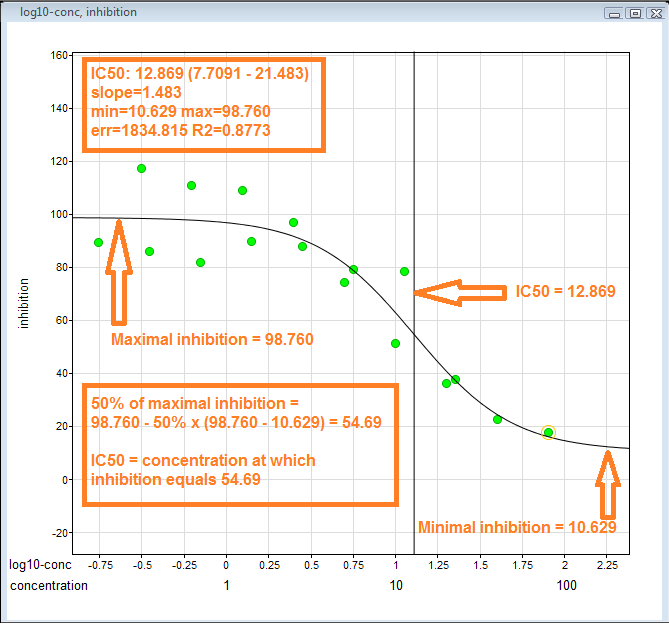

In [14]:
import numpy as np
def pIC50(dataframe):
    pIC50 = []
    for i in dataframe['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))
    dataframe['pIC50'] = pIC50
    x = dataframe.drop('standard_value_norm', 1)   
    return x
                   
def norm_value(dataframe):
    norm = []
    for i in dataframe['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)
    dataframe['standard_value_norm'] = norm
    x = dataframe.drop('standard_value', 1)    
    return x

We will first apply the norm_value() function to normalize the values in the standard_value column.

In [15]:
df_norm = norm_value(final_df_combined)
df_norm

ChEMBL ID  AlogP    PSA HBA HBD  \
2     CHEMBL394875  -0.24  63.32   3   2   
4     CHEMBL200381   5.04  86.52   6   2   
7     CHEMBL502351   4.62  52.31   5   0   
8     CHEMBL492572   4.59  70.13   4   2   
9     CHEMBL492591   1.46  66.23   2   2   
..             ...    ...    ...  ..  ..   
990   CHEMBL514344   6.33  85.47   5   2   
992  CHEMBL1410068   5.45  68.90   5   1   
996     CHEMBL1099   0.03  55.40   3   1   
997    CHEMBL99377   2.08  38.33   2   1   
998   CHEMBL344151   3.15  12.03   1   1   

                                                Smiles       MW  \
2                                    CSC[C@H](N)C(=O)O  352.397   
4        N#Cc1cnc2cnc(NCc3cccnc3)cc2c1Nc1ccc(F)c(Cl)c1  151.121   
7          COc1ccc(-c2cnc3c(-c4cccc5ncccc45)cnn3c2)cc1  380.806   
8    C[C@@H](CN1CCC(n2c(=O)[nH]c3cc(Cl)ccc32)CC1)NC...  603.601   
9                                O=C(O)c1cc2occc2[nH]1  337.261   
..                                                 ...      ...   
990  CCOc1cc(C(=O)Nc2ccc(Cl)c(-c3nc4ccccc4[nH]3)c2)...  163.173   
992  CC1(C)C=Cc2c(c3c(c4c(=O)c(-c5ccc(O)cc5)coc24)O...  388.886   
996                                  CC1(C)OC(=O)NC1=O  449.639   
997                         CCC(=O)NC1CCc2cccc(OC)c2C1  357.563   
998  C[C@]12N[C@H](Cc3ccccc31)c1ccccc12.O=C(O)/C=C\...  367.788   

     standard_value_norm  
2               63000.00  
4                  50.00  
7                3000.00  
8                  46.00  
9                 141.00  
..                   ...  
990                30.00  
992              3220.00  
996           1000000.00  
997                 0.48  
998                 0.10  

[415 rows x 8 columns]

In [16]:
df_final = pIC50(df_norm)
df_final

ChEMBL ID  AlogP    PSA HBA HBD  \
2     CHEMBL394875  -0.24  63.32   3   2   
4     CHEMBL200381   5.04  86.52   6   2   
7     CHEMBL502351   4.62  52.31   5   0   
8     CHEMBL492572   4.59  70.13   4   2   
9     CHEMBL492591   1.46  66.23   2   2   
..             ...    ...    ...  ..  ..   
990   CHEMBL514344   6.33  85.47   5   2   
992  CHEMBL1410068   5.45  68.90   5   1   
996     CHEMBL1099   0.03  55.40   3   1   
997    CHEMBL99377   2.08  38.33   2   1   
998   CHEMBL344151   3.15  12.03   1   1   

                                                Smiles       MW      pIC50  
2                                    CSC[C@H](N)C(=O)O  352.397   4.200659  
4        N#Cc1cnc2cnc(NCc3cccnc3)cc2c1Nc1ccc(F)c(Cl)c1  151.121   7.301030  
7          COc1ccc(-c2cnc3c(-c4cccc5ncccc45)cnn3c2)cc1  380.806   5.522879  
8    C[C@@H](CN1CCC(n2c(=O)[nH]c3cc(Cl)ccc32)CC1)NC...  603.601   7.337242  
9                                O=C(O)c1cc2occc2[nH]1  337.261   6.850781  
..                                                 ...      ...        ...  
990  CCOc1cc(C(=O)Nc2ccc(Cl)c(-c3nc4ccccc4[nH]3)c2)...  163.173   7.522879  
992  CC1(C)C=Cc2c(c3c(c4c(=O)c(-c5ccc(O)cc5)coc24)O...  388.886   5.492144  
996                                  CC1(C)OC(=O)NC1=O  449.639   3.000000  
997                         CCC(=O)NC1CCc2cccc(OC)c2C1  357.563   9.318759  
998  C[C@]12N[C@H](Cc3ccccc31)c1ccccc12.O=C(O)/C=C\...  367.788  10.000000  

[415 rows x 8 columns]

## Data Visualization

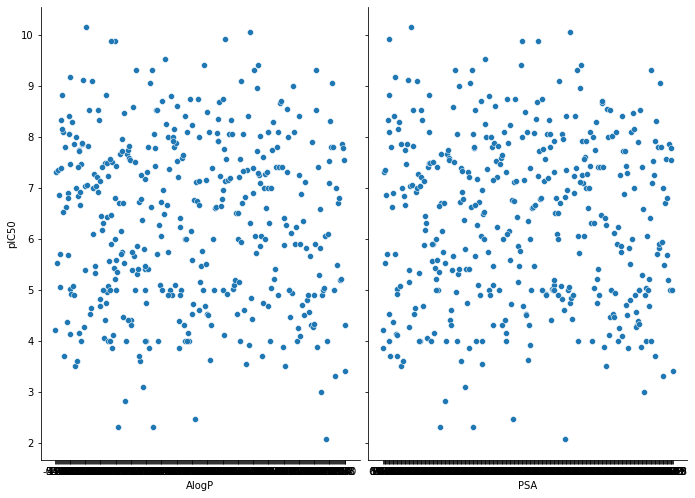

In [65]:
sns.pairplot(df_final, x_vars=['AlogP','PSA'], y_vars='pIC50', height=7, aspect=0.7);

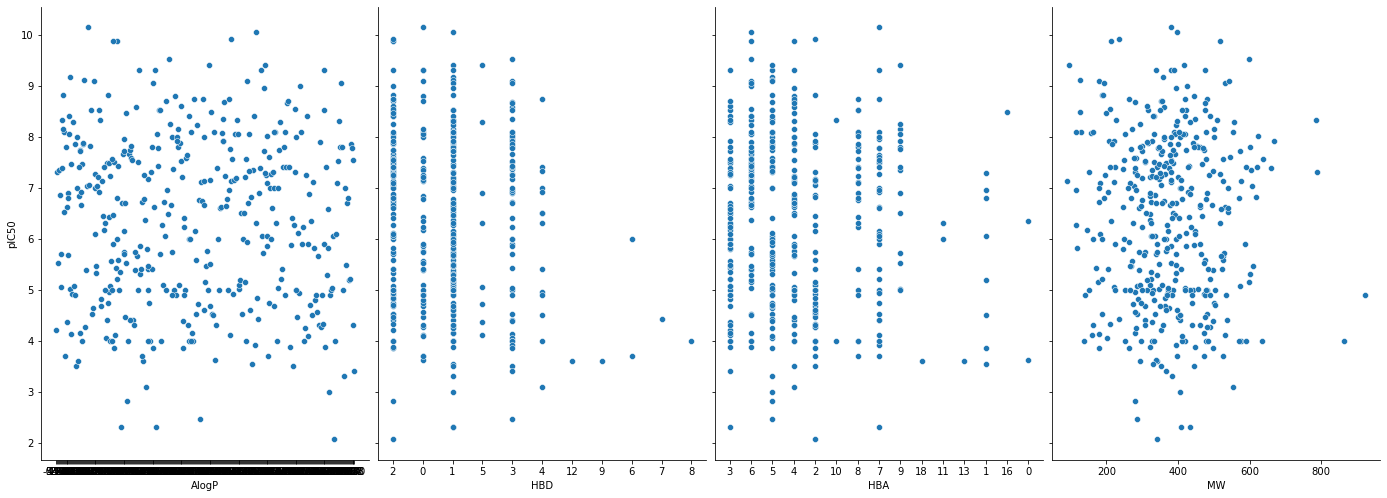

In [66]:
sns.pairplot(df_final, x_vars=['AlogP','HBD','HBA','MW'], y_vars='pIC50', height=7, aspect=0.7);

## Generating a Detailed Report of the data

In [67]:
df_final.profile_report(title="Data Report")
profile = pandas_profiling.ProfileReport(df_final) 
profile.to_file("covid/Data Report.html")

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Form all the above graphs; It is too easy to see that there is no clear linear, polynomial relation between pIC50 and other features.

# Applying Multiple Models

## Multiple Linear Regression

In [24]:
from sklearn.linear_model import LinearRegression
feature_cols = ['AlogP','HBA','HBD','MW','PSA']
X = df_final[feature_cols]
y = df_final.pIC50# instantiate and fit
lm1 = LinearRegression()
lm1.fit(X, y)# print the coefficients
print(lm1.intercept_)
print(lm1.coef_)# pair the feature names with the coefficients
list(zip(feature_cols, lm1.coef_))

4.563272167504385
[ 0.24874847  0.08717587 -0.17163662  0.00066841  0.00705015]


[('AlogP', 0.24874846854029226),
 ('HBA', 0.08717586615767486),
 ('HBD', -0.1716366168713897),
 ('MW', 0.0006684101418389238),
 ('PSA', 0.007050153735623871)]

## Linear Regression

RMSE : 1.6951429686082224
R^2:  -0.008587326794472494


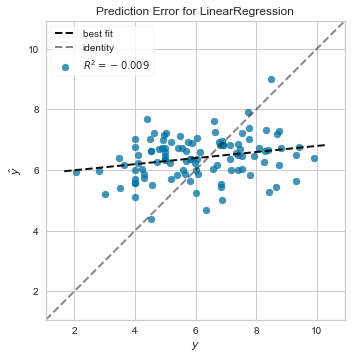

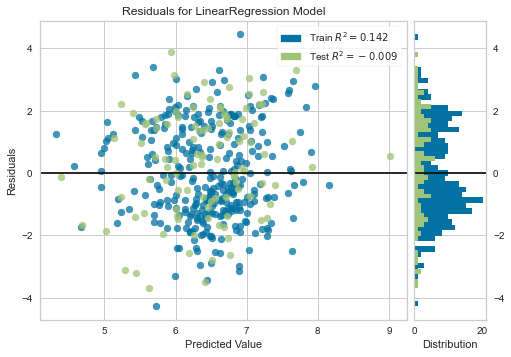

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)
lm4 = LinearRegression()
lm4.fit(X_train, y_train)
lm4_preds = lm4.predict(X_test)
print("RMSE :", np.sqrt(mean_squared_error(y_test, lm4_preds)))
print("R^2: ", r2_score(y_test, lm4_preds))
from yellowbrick.regressor import PredictionError, ResidualsPlot
visualizer = PredictionError(lm4)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()
visualizer = ResidualsPlot(lm4)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 
visualizer.poof()

In [18]:
df_final.to_csv(r'extracted_data.csv', index = False)
df3 = pd.read_csv('extracted_data.csv')
df3.head()

ChEMBL ID  AlogP    PSA  HBA  HBD  \
0  CHEMBL394875  -0.24  63.32    3    2   
1  CHEMBL200381   5.04  86.52    6    2   
2  CHEMBL502351   4.62  52.31    5    0   
3  CHEMBL492572   4.59  70.13    4    2   
4  CHEMBL492591   1.46  66.23    2    2   

                                              Smiles       MW     pIC50  
0                                  CSC[C@H](N)C(=O)O  352.397  4.200659  
1      N#Cc1cnc2cnc(NCc3cccnc3)cc2c1Nc1ccc(F)c(Cl)c1  151.121  7.301030  
2        COc1ccc(-c2cnc3c(-c4cccc5ncccc45)cnn3c2)cc1  380.806  5.522879  
3  C[C@@H](CN1CCC(n2c(=O)[nH]c3cc(Cl)ccc32)CC1)NC...  603.601  7.337242  
4                              O=C(O)c1cc2occc2[nH]1  337.261  6.850781

In [28]:
df3.shape

(415, 8)

Making a molecule.smi file which has Smiles and Chenmbl_id as two columns

In [19]:
selection = ['Smiles','ChEMBL ID']
df3_selection = df3[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

### **PaDEL Descriptor**

To get the PaDEL Descriptors first, you have to create .smi file containing Smile and CHEMBL_id In this order only. Once you have this file, Use padel-Descriptor.jar file in directory : 'padel/PaDEL-Descriptor' to obtain 'descriptors_output.csv' in your working directory.<br>
Below is the image of software PaDEL-Descriptor.

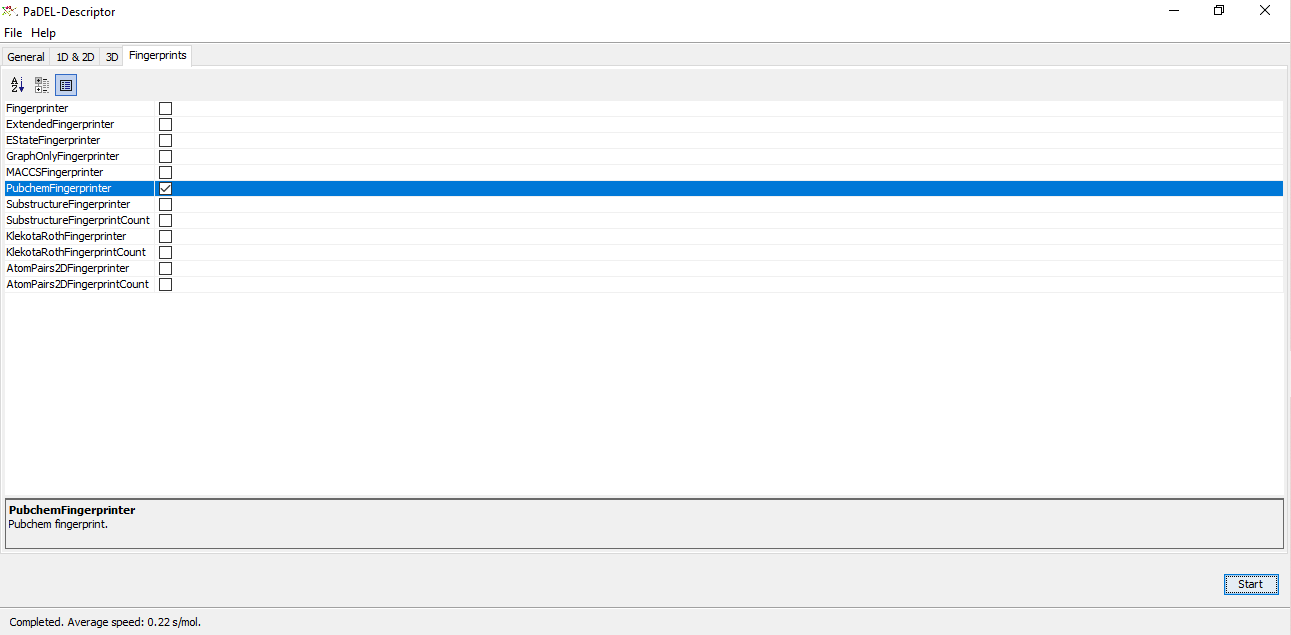

In [30]:
df3_X = pd.read_csv('descriptors_output.csv')
df3_X.rename(columns = {'Name':'ChEMBL ID'}, inplace = True)
df3_X.head(-5)

ChEMBL ID  PubchemFP0  PubchemFP1  PubchemFP2  PubchemFP3  \
0     CHEMBL394875           1           1           0           0   
1     CHEMBL200381           1           1           0           0   
2     CHEMBL502351           1           1           1           0   
3     CHEMBL492572           1           1           1           0   
4     CHEMBL492591           1           0           0           0   
..             ...         ...         ...         ...         ...   
405   CHEMBL254760           1           1           1           0   
406   CHEMBL539507           1           1           0           0   
407  CHEMBL1553629           1           1           1           0   
408   CHEMBL473159           1           0           0           0   
409   CHEMBL464859           1           1           1           0   

     PubchemFP4  PubchemFP5  PubchemFP6  PubchemFP7  PubchemFP8  ...  \
0             0           0           0           0           0  ...   
1             0           0           0           0           0  ...   
2             0           0           0           0           0  ...   
3             0           0           0           0           0  ...   
4             0           0           0           0           0  ...   
..          ...         ...         ...         ...         ...  ...   
405           0           0           0           0           0  ...   
406           0           0           0           0           0  ...   
407           0           0           0           0           0  ...   
408           0           0           0           0           0  ...   
409           0           0           0           0           0  ...   

     PubchemFP871  PubchemFP872  PubchemFP873  PubchemFP874  PubchemFP875  \
0               0             0             0             0             0   
1               0             0             0             0             0   
2               0             0             0             0             0   
3               0             0             0             0             0   
4               0             0             0             0             0   
..            ...           ...           ...           ...           ...   
405             0             0             0             0             0   
406             0             0             0             0             0   
407             0             0             0             0             0   
408             0             0             0             0             0   
409             0             0             0             0             0   

     PubchemFP876  PubchemFP877  PubchemFP878  PubchemFP879  PubchemFP880  
0               0             0             0             0             0  
1               0             0             0             0             0  
2               0             0             0             0             0  
3               0             0             0             0             0  
4               0             0             0             0             0  
..            ...           ...           ...           ...           ...  
405             0             0             0             0             0  
406             0             0             0             0             0  
407             0             0             0             0             0  
408             0             0             0             0             0  
409             0             0             0             0             0  

[410 rows x 882 columns]

In [31]:
df_final2=pd.merge(df_final, df3_X, on='ChEMBL ID')
df_final2.head()

ChEMBL ID  AlogP    PSA HBA HBD  \
0  CHEMBL394875  -0.24  63.32   3   2   
1  CHEMBL200381   5.04  86.52   6   2   
2  CHEMBL502351   4.62  52.31   5   0   
3  CHEMBL492572   4.59  70.13   4   2   
4  CHEMBL492591   1.46  66.23   2   2   

                                              Smiles       MW     pIC50  \
0                                  CSC[C@H](N)C(=O)O  352.397  4.200659   
1      N#Cc1cnc2cnc(NCc3cccnc3)cc2c1Nc1ccc(F)c(Cl)c1  151.121  7.301030   
2        COc1ccc(-c2cnc3c(-c4cccc5ncccc45)cnn3c2)cc1  380.806  5.522879   
3  C[C@@H](CN1CCC(n2c(=O)[nH]c3cc(Cl)ccc32)CC1)NC...  603.601  7.337242   
4                              O=C(O)c1cc2occc2[nH]1  337.261  6.850781   

   PubchemFP0  PubchemFP1  ...  PubchemFP871  PubchemFP872  PubchemFP873  \
0           1           1  ...             0             0             0   
1           1           1  ...             0             0             0   
2           1           1  ...             0             0             0   
3           1           1  ...             0             0             0   
4           1           0  ...             0             0             0   

   PubchemFP874  PubchemFP875  PubchemFP876  PubchemFP877  PubchemFP878  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   PubchemFP879  PubchemFP880  
0             0             0  
1             0             0  
2             0             0  
3             0             0  
4             0             0  

[5 rows x 889 columns]

In [32]:
df3_X = df_final2.drop(columns=['ChEMBL ID','AlogP','PSA','HBD','HBA','Smiles','MW','pIC50'])
df3_X.head()
df3_Y = df_final2['pIC50']
df3_Y
dataset3 = pd.concat([df3_X,df3_Y], axis=1)
dataset3.head(-10)
dataset3 = dataset3.dropna()
dataset3.head()

PubchemFP0  PubchemFP1  PubchemFP2  PubchemFP3  PubchemFP4  PubchemFP5  \
0           1           1           0           0           0           0   
1           1           1           0           0           0           0   
2           1           1           1           0           0           0   
3           1           1           1           0           0           0   
4           1           0           0           0           0           0   

   PubchemFP6  PubchemFP7  PubchemFP8  PubchemFP9  ...  PubchemFP872  \
0           0           0           0           1  ...             0   
1           0           0           0           1  ...             0   
2           0           0           0           1  ...             0   
3           0           0           0           1  ...             0   
4           0           0           0           1  ...             0   

   PubchemFP873  PubchemFP874  PubchemFP875  PubchemFP876  PubchemFP877  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   PubchemFP878  PubchemFP879  PubchemFP880     pIC50  
0             0             0             0  4.200659  
1             0             0             0  7.301030  
2             0             0             0  5.522879  
3             0             0             0  7.337242  
4             0             0             0  6.850781  

[5 rows x 882 columns]

In [21]:
df3_selection.shape

(415, 2)

## Random Forest Regressor

R2 score of this model is 0.10519265634773267


C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

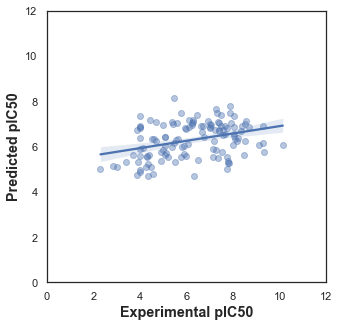

In [38]:
from sklearn.metrics import r2_score
X_train, X_test, Y_train, Y_test = train_test_split(df3_X, df3_Y, test_size=0.3)
i=0
for i in range(10):
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X_train, Y_train)
    r2 = model.score(X_test, Y_test)
    #print(r2)
    i+=1
Y_pred = model.predict(X_test)
print('R2 score of this model is',r2_score(Y_test, Y_pred))

import seaborn as sns

import matplotlib.pyplot as plt
sns.set(color_codes=True)
sns.set_style("white")
ax = sns.regplot(Y_test, Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

### Brief about R2 Score :

The R2 score 20 tells you how successfully your model accounts for the intrinsic variation in the data. The R2 score comes from running the trained model on the Validation data.  The R2 score predict the generalizability of your model – i.e. its expected performance on new, unseen data.

R-Squared only works as intended in a simple linear regression model with one explanatory variable. With a multiple regression made up of several independent variables, the R-Squared must be adjusted.

The adjusted R-squared compares the descriptive power of regression models that include diverse numbers of predictors. Every predictor added to a model increases R-squared and never decreases it. Thus, a model with more terms may seem to have a better fit just for the fact that it has more terms, while the adjusted R-squared compensates for the addition of variables and only increases if the new term enhances the model above what would be obtained by probability and decreases when a predictor enhances the model less than what is predicted by chance.

In an overfitting condition, an incorrectly high value of R-squared is obtained, even when the model actually has a decreased ability to predict. This is not the case with the adjusted R-squared

# Conclusion

Random Forest Regressor works fine in comparison to the other methods. But as there is no clear relationship between descriptors and bioactivity(pIC50 values), The conventional Methods are not enough to predict bioactivity with high accuracy, we need something more powerful than conventional machine learning method like we need CNN, neural network or GANs to predicts these value more accurately.